References:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://www.youtube.com/watch?v=aLOQD66Sj0g

https://contrib.scikit-learn.org/category_encoders/targetencoder.html

https://scikit-learn.org/stable/modules/cross_validation.html#stratification

https://www.youtube.com/watch?v=PxgVFp5a0E4

https://youtu.be/4i4C3ejTdgs?si=XfCjQW5h-ABD0Bu9

https://scikit-learn.sourceforge.net/dev/modules/model_evaluation.html (ref to different 'scoring')

https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.plot_importance

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from xgboost import plot_importance

pd.set_option('display.max_rows', None)

In [2]:
baseDF = pd.read_csv("edaMovies.csv")

In [3]:
baseDF.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,Success
0,The Shining,NC-17,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,True
1,The Blue Lagoon,NC-17,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,True
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,True
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,True
4,Caddyshack,NC-17,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,True


## Preparing Data

In [4]:
baseDFF = baseDF.drop(columns=['name','Success','released','gross','runtime','genre',
                               'rating','director','writer','star','country','company'])
succDF = baseDF["Success"]

#stratify ensures proportional split for succDF 
base_train, base_test, succ_train, succ_test = train_test_split(baseDFF, succDF, stratify=succDF ,test_size=0.2, random_state=20) 

In [5]:
baseDFF.head()

,year,score,votes,budget
0,1980,8.4,927000.0,19000000.0
1,1980,5.8,65000.0,4500000.0
2,1980,8.7,1200000.0,18000000.0
3,1980,7.7,221000.0,3500000.0
4,1980,7.3,108000.0,6000000.0


## Establishing Pipeline to be used for XGBoost

In [6]:
estimators = [('clf', XGBClassifier(random_state=20))]
pipe=Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=20, ...))])

In [7]:
search_space = {
    'clf__max_depth': Integer(2,10),
    'clf__learning_rate': Real(0.005, 1.0, prior='log-uniform'), 
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

#BayesSearchCV used to find the best model
opt = BayesSearchCV(pipe, search_space, cv=5, n_iter=20, scoring='f1',random_state=30)
#'clf__learning_rate' impacts the "fit"
#n_iter -> iteration with differing search_space WRT differing ranges defined 

'f1' seems to be the most suitable to "score" the model as the intention is to find the best model, whereafter, the model will be fitted against other test datasets which were prepared.

In [8]:
opt.fit(base_train,succ_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__learning_rate': Real(low=0.005, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [9]:
print("f1 score of trained set    : ",opt.best_score_)
print("f1 score of test set       : ",opt.score(base_test,succ_test))

f1 score of trained set    :  0.789846291807741
f1 score of test set       :  0.7813953488372094


In [10]:
testDF=pd.read_csv("testDataOne.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100 #the data retrieved scaled down the votes

testRight=testDF["Success"]

In [11]:
print("f1 score of prepared set 1 : ", opt.score(testLeft,testRight))

f1 score of prepared set 1 :  0.7861089187056037


In [12]:
testDF=pd.read_csv("testDataTwo.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100

testRight=testDF["Success"]

In [13]:
print("f1 score of prepared set 2 : ", opt.score(testLeft,testRight))

f1 score of prepared set 2 :  0.7608874281018898


In [14]:
testDF=pd.read_csv("testDataThree.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100

testRight=testDF["Success"]

In [15]:
print("f1 score of prepared set 3 : ", opt.score(testLeft,testRight))

f1 score of prepared set 3 :  0.8117359413202934


Accuracy (for additional reference)

In [16]:
opt = BayesSearchCV(pipe, search_space, cv=5, n_iter=20, scoring='accuracy',random_state=30)
opt.fit(base_train,succ_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__learning_rate': Real(low=0.005, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [17]:
print("Accuracy of trained set    : ",opt.best_score_)
print("Accuracy of test set       : ",opt.score(base_test,succ_test))

Accuracy of trained set    :  0.7575900500550714
Accuracy of test set       :  0.742296918767507


In [18]:
testDF=pd.read_csv("testDataOne.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100 

testRight=testDF["Success"]

In [19]:
print("Accuracy of prepared set 1 : ", opt.score(testLeft,testRight))

Accuracy of prepared set 1 :  0.711


In [20]:
testDF=pd.read_csv("testDataTwo.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100

testRight=testDF["Success"]

In [21]:
print("Accuracy of prepared set 2 : ", opt.score(testLeft,testRight))

Accuracy of prepared set 2 :  0.716


In [22]:
testDF=pd.read_csv("testDataThree.csv")
testLeft=testDF.drop(columns=['Success','release_date','revenue'])
testLeft=testLeft.rename(columns={'budget':'budget',"vote_average":'score',"vote_count":'votes','year':'year'})
testLeft=testLeft[['year', 'score', 'votes', 'budget']]
testLeft["votes"]=testLeft["votes"]*100 

testRight=testDF["Success"]

In [23]:
print("Accuracy of prepared set 3 : ", opt.score(testLeft,testRight))

Accuracy of prepared set 3 :  0.758


### The f1 score and accuracy observed indicates the model is relatively good at predicting the success of a movie and it is further supported by the high f1 scores and accuracy from the additional datasets.

## Plot Importance (Relevance of variable)

<Axes: title={'center': 'Plot Importance (Weight)'}, xlabel='Weight', ylabel='Variables'>

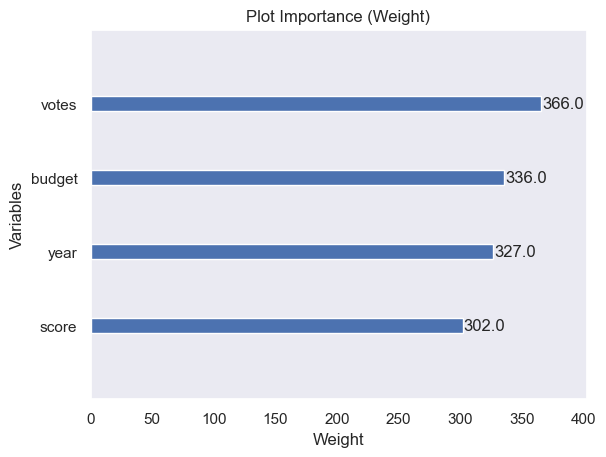

In [24]:
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]

plot_importance(xgboost_model,grid=False,importance_type='weight',xlabel='Weight',ylabel='Variables',title="Plot Importance (Weight)") 
#counts the number of times each feature appeared in the tree

<Axes: title={'center': 'Plot Importance (Gain)'}, xlabel='Gain', ylabel='Variables'>

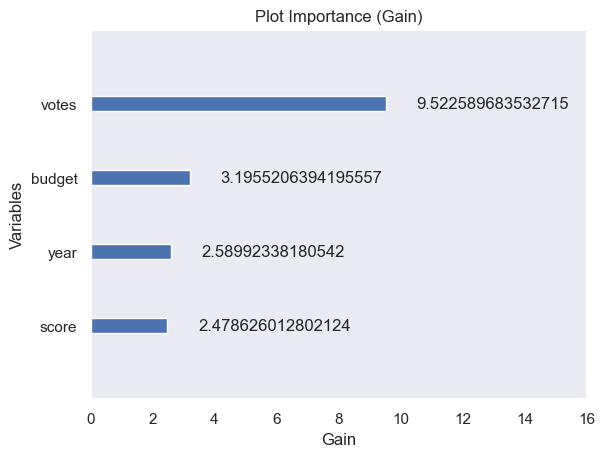

In [25]:
plot_importance(xgboost_model,grid=False,importance_type='gain',xlabel='Gain',xlim=(0,16),ylabel='Variables',title="Plot Importance (Gain)")
#average gain of splits which use the feature

<Axes: title={'center': 'Plot Importance (Cover)'}, xlabel='cover', ylabel='Variables'>

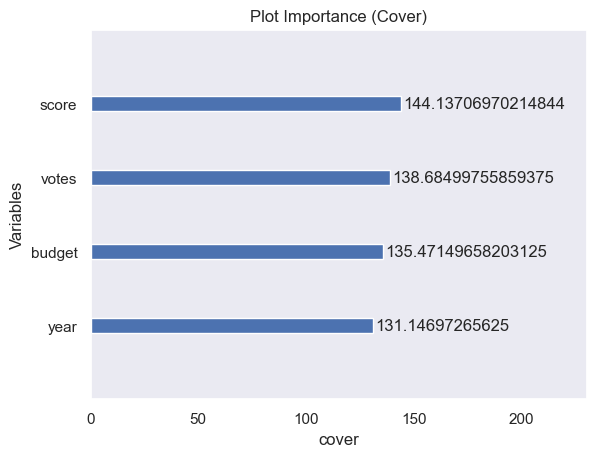

In [26]:
plot_importance(xgboost_model,grid=False,importance_type='cover',xlabel='cover',xlim=(0,230),ylabel='Variables',title="Plot Importance (Cover)") 
#number of samples affected by the split on average

From the plot_importance available, the most impactful variable in predicting a successful movie is "votes" followed by "budget". This is perhaps unexpected due to how budget proves to impact gross more from the EDA and is directly tied in to the "Success" quantified in this project. 

Votes serves as an easy indicator of success when it is high enough, as votes would indirectly indicate popularity which contributes to the success. Votes to gross also have a relatively high, but lowered correlation when compared to budget to gross. Altogether making it surprising when it outweighs the other variable used to this extent.

Additional Observation:

Given the robustness of XGBoost and the amount of variable used for this model, it is possible to hypothesize that other variables which relate to human interactions are probably required to better predict the success of movies and this is one of the better models that can be gotten for the dataset which is used. "Votes" which is a variable relating to human interaction had the most impact, what if there was a "popularity" variable of the film or "votes" variable which relates to popularity of the casts in the film? The randomness in reception from human interaction can only be answered by such variables.

### Additional details of model (For reference)

In [27]:
#The model chosen from the iteration (best)
opt.best_params_

OrderedDict([('clf__colsample_bylevel', 0.8034732278752568),
             ('clf__colsample_bynode', 0.9994577404305747),
             ('clf__colsample_bytree', 0.9946493734846681),
             ('clf__gamma', 0.5212503739484576),
             ('clf__learning_rate', 0.11656274171480678),
             ('clf__max_depth', 7),
             ('clf__reg_alpha', 0.7334149214536402),
             ('clf__reg_lambda', 9.686202734050088),
             ('clf__subsample', 0.5294781855652393)])

In [28]:
opt.cv_results_

{'mean_fit_time': array([0.05806561, 0.08431435, 0.08612361, 0.07154918, 0.09261332,
        0.06605015, 0.12445297, 0.11399469, 0.08687329, 0.05100465,
        0.03476162, 0.05993009, 0.06045747, 0.2107439 , 0.0537746 ,
        0.06177173, 0.04916377, 0.04164991, 0.04285231, 0.20694437]),
 'std_fit_time': array([0.00067787, 0.00138461, 0.00128786, 0.00080016, 0.00151056,
        0.00451894, 0.00157045, 0.00204941, 0.00225051, 0.00144774,
        0.00069621, 0.00179464, 0.00094698, 0.00723109, 0.00114312,
        0.00235265, 0.00113701, 0.00118785, 0.00152673, 0.00200804]),
 'mean_score_time': array([0.00220523, 0.00201225, 0.00229678, 0.00201349, 0.00212197,
        0.00241189, 0.00272107, 0.00231328, 0.00239344, 0.00222883,
        0.00220408, 0.00228186, 0.0021606 , 0.00309939, 0.00228729,
        0.0024775 , 0.00251498, 0.00286746, 0.00259356, 0.00311031]),
 'std_score_time': array([4.06107894e-04, 1.30133744e-05, 5.03998348e-04, 3.92067447e-05,
        2.00431419e-04, 4.96603006e-

In [29]:
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.8034732278752568,
                               colsample_bynode=0.9994577404305747,
                               colsample_bytree=0.9946493734846681, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.5212503739484576,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.11656274171480678, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=20, ...))])

In [30]:
opt.best_estimator_.steps

[('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.8034732278752568,
                colsample_bynode=0.9994577404305747,
                colsample_bytree=0.9946493734846681, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0.5212503739484576,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.11656274171480678,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=20, ...))]